# SEM MRes 2021 
## 02-ASE-GPAW-EffectiveMass

OK! In this notebook we are going to use as our starting point the LCAO calculation from the previous work, but now go and calculate the effective mass by 'hand' from inspecting the eigenenergies returned by the band structure calculation. 

In [1]:
import matplotlib.pyplot as plt
# change defaults to make plots bigger
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 dpi is really fine, but slower (i.e. for publication)

In [2]:
from ase.spacegroup import crystal
from ase.visualize import view
from ase.io import read
from ase.build import bulk
from ase.optimize import BFGS
from ase.optimize import BFGSLineSearch
from gpaw import GPAW, PW, FermiDirac
import matplotlib.pyplot as plt
from ase.dft.dos import DOS
from ase.constraints import UnitCellFilter
from ase.build import mx2
from gpaw import *
from ase.constraints import StrainFilter
from gpaw.xc.vdw import VDWFunctional
vdw = VDWFunctional('vdW-DF2', Nalpha=24)

atoms=read('MoSeWS.traj')
calc = GPAW(mode=PW(600),
            xc='vdW-DF2',
            nbands=70,
            convergence={'bands': -20},
            setups={'Mo, W': '6'},      
            parallel={'band': 1, 'domain': 1},
            occupations=FermiDirac(width=0.01),
            kpts={'size': (42, 42, 1), 'gamma': True})  
atoms.calc = calc
atoms.get_potential_energy()
calc.write('gs_new.gpw', mode='all')


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.8.0
 |___|_|             

User:   tewodros@tewodros-HP-Pavilion-Laptop-14-bf0xx
Date:   Fri May 16 12:40:51 2025
Arch:   x86_64
Pid:    21584
CWD:    /home/tewodros/Desktop/Hetrostructure/HTR/revised/HTR/1T_2H/MoSe2-WS2
Python: 3.7.12
gpaw:   /home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/tewodros/miniconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/tewodros/miniconda3/lib/python3.7/site-packages/ase (version 3.22.1)
numpy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/numpy (version 1.21.6)
scipy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/scipy (version 1.7.3)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: True
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: -20}
  kpts: {gamma: True,
         size: (42, 42, 1)}
  mode: {ecut: 600.0,
         name: pw}
  nbands: 70
  occupations:

     iter     time        total  log10-change:
                         energy  eigst   dens
iter:   1 12:58:55  -460.881256  +2.06
iter:   2 13:08:17  -460.368970  +0.56  -1.15
iter:   3 13:17:07  -459.553600  -0.88  -1.21
iter:   4 13:25:46  -459.361080  -2.09  -1.39
iter:   5 13:34:30  -459.348397  -2.02  -1.52
iter:   6 13:43:25  -459.361660c -2.50  -1.75
iter:   7 13:52:17  -459.367854c -2.98  -1.95
iter:   8 14:01:09  -459.335878  -2.91  -2.11
iter:   9 14:09:57  -459.335857  -4.70  -2.60
iter:  10 14:18:43  -459.335839c -4.85  -2.63
iter:  11 14:27:35  -459.335947c -4.48  -2.79
iter:  12 14:36:15  -459.335845c -5.03  -3.20
iter:  13 14:45:16  -459.335844c -6.38  -3.43
iter:  14 14:54:45  -459.335837c -6.16  -3.48
iter:  15 15:03:33  -459.335831c -6.73  -3.60
iter:  16 15:12:22  -459.335826c -6.58  -3.72
iter:  17 15:21:25  -459.335825c -7.38  -3.91
iter:  18 15:32:05  -459.335826c -7.62c -4.02c

Converged after 18 iterations.

Dipole moment: (2.930270, -3.364606, 0.188240) |e|*A

In [3]:
# OK, sanity checks on that calculation!
# What is the band-gap, and does it look sensible?
from ase.dft.bandgap import bandgap
gap, p1, p2 = bandgap(atoms.calc)
# Output is the gap in eV
# and from where the VBM in k-space is, and where the CBM is.
# From here you can appreciate whether the material is direct or not.

Gap: 1.016 eV
Transition (v -> c):
  (s=0, k=602, n=25, [0.33, 0.33, 0.00]) -> (s=0, k=602, n=26, [0.33, 0.33, 0.00])


HEX(a=3.24777, c=14.9156)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



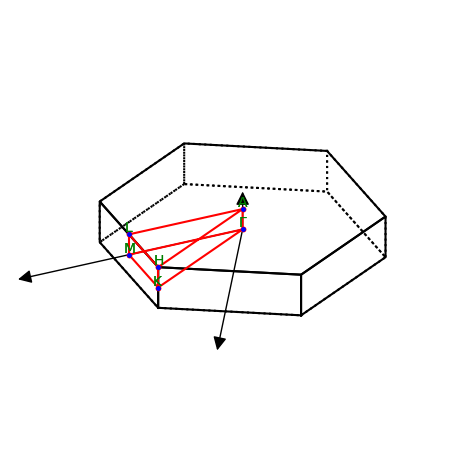

<Axes3DSubplot:>

In [4]:
# OK! Luckily ASE knows all about space groups and the reciprocal lattice.
# So let's ask it what it knows about this one, and a suggested high-symmetry path.
lat = atoms.cell.get_bravais_lattice()
print(lat.description())
lat.plot_bz(show=True)

In [5]:
bs_calc = calc.fixed_density(kpts={'path': 'GMKGALHA', 'npoints': 100}, symmetry='off')
 # path through k-space taken from Materials project; or from analysis above

bs_calc.get_potential_energy() # eval at these k-point path
bs = bs_calc.band_structure().subtract_reference()
#bs=bs_calc.band_structure() # generate the plot object
#bs.ylabel(r'$\varepsilon_N(k)$ [eV]', size=24)
bs.plot(ylabel=r'$\mathrm{\varepsilon_N}$ [eV]', label=r'$\mathrm{MoSe_{2}-WS_{2}}$', loc="upper right", color='r', emax=4, emin=-4)
plt.grid(which='major', axis='both', zorder=-1.0, color = 'green', linestyle = '--', linewidth = 0.05)
plt.tight_layout()
#plt.savefig('MoS2-MoS2.eps')
plt.show()


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.8.0
 |___|_|             

User:   tewodros@tewodros-HP-Pavilion-Laptop-14-bf0xx
Date:   Fri May 16 15:36:40 2025
Arch:   x86_64
Pid:    21584
CWD:    /home/tewodros/Desktop/Hetrostructure/HTR/revised/HTR/1T_2H/MoSe2-WS2
Python: 3.7.12
gpaw:   /home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/tewodros/miniconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/tewodros/miniconda3/lib/python3.7/site-packages/ase (version 3.22.1)
numpy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/numpy (version 1.21.6)
scipy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/scipy (version 1.7.3)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: True
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: -20}
  gpts: [20 20 90]
  kpts: {npoints: 100,
         path: GMKGALHA}
  mode: {ecut: 600.0,
         name: pw}
  nbands: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/tewodros/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a211ecf99d0d>", line 1, in <module>
    bs_calc = calc.fixed_density(kpts={'path': 'GMKGALHA', 'npoints': 100}, symmetry='off')
  File "/home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw/calculator.py", line 217, in fixed_density
    calc.calculate(system_changes=[])
  File "/home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw/calculator.py", line 353, in calculate
    for _ in self.icalculate(atoms, properties, system_changes):
  File "/home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw/calculator.py", line 383, in icalculate
    self.set_positions(atoms)
  File "/home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw/calculator.py", line 581, in set_positions
    self.spos_ac)
  File "/home/tewodros/miniconda3/lib/python3.7/site-p

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Get the accurate HOMO and LUMO from the band structure calculator
KS_gap, p1, p2 = bandgap(bs_calc)
#KS_gap, homo, lumo = bs_calc.get_homo_lumo()

In [ ]:
KS_gap